# IESB - Miner II - Aula 05 - Random Forest

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/costa-rican-household-poverty-prediction/sample_submission.csv
/kaggle/input/costa-rican-household-poverty-prediction/codebook.csv
/kaggle/input/costa-rican-household-poverty-prediction/train.csv.zip
/kaggle/input/costa-rican-household-poverty-prediction/sample_submission.csv.zip
/kaggle/input/costa-rican-household-poverty-prediction/codebook.xlsx
/kaggle/input/costa-rican-household-poverty-prediction/train.csv
/kaggle/input/costa-rican-household-poverty-prediction/test.csv
/kaggle/input/costa-rican-household-poverty-prediction/test.csv.zip


In [2]:
# Carregando os dados
df = pd.read_csv('/kaggle/input/costa-rican-household-poverty-prediction/train.csv')
test = pd.read_csv('/kaggle/input/costa-rican-household-poverty-prediction/test.csv')

df.shape, test.shape

((9557, 143), (23856, 142))

In [3]:
# Juntando os dataframes
df_all = df.append(test)

df_all.shape

(33413, 143)

In [4]:
# Vamos visualizar os dados
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33413 entries, 0 to 23855
Columns: 143 entries, Id to Target
dtypes: float64(9), int64(129), object(5)
memory usage: 36.7+ MB


In [5]:
# Vamos aumentar o número de colunas ara o info mostrar
df_all.info(max_cols=145)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33413 entries, 0 to 23855
Data columns (total 143 columns):
 #    Column           Non-Null Count  Dtype  
---   ------           --------------  -----  
 0    Id               33413 non-null  object 
 1    v2a1             9150 non-null   float64
 2    hacdor           33413 non-null  int64  
 3    rooms            33413 non-null  int64  
 4    hacapo           33413 non-null  int64  
 5    v14a             33413 non-null  int64  
 6    refrig           33413 non-null  int64  
 7    v18q             33413 non-null  int64  
 8    v18q1            7945 non-null   float64
 9    r4h1             33413 non-null  int64  
 10   r4h2             33413 non-null  int64  
 11   r4h3             33413 non-null  int64  
 12   r4m1             33413 non-null  int64  
 13   r4m2             33413 non-null  int64  
 14   r4m3             33413 non-null  int64  
 15   r4t1             33413 non-null  int64  
 16   r4t2             33413 non-null  int64

In [6]:
# Quais colunas do dataframe são do tipo object
df_all.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


In [7]:
# Olhando a coluna dependency
df_all['dependency'].value_counts()

yes          7580
no           6036
.5           5175
2            2499
1.5          2471
.33333334    2131
.66666669    1617
8            1415
.25           944
3             832
1.3333334     362
.2            306
2.5           301
.75           301
4             295
.40000001     259
.60000002     136
1.6666666     128
5             120
1.25           72
.80000001      63
.16666667      63
3.5            36
.83333331      33
.14285715      32
2.3333333      30
2.25           26
1.2            22
.2857143       18
7              16
6              14
.85714287      13
3.3333333      13
.71428573      12
.375           11
1.75           11
.22222222      11
.125            9
Name: dependency, dtype: int64

### Vamos investigar o valor 'yes' na coluna dependency

In [8]:
# Vamos obter o idhogar de alguns casos
df_all[df_all['dependency'] == 'yes']['idhogar'].head()

3    2b58d945f
4    2b58d945f
5    2b58d945f
6    2b58d945f
7    d6dae86b7
Name: idhogar, dtype: object

In [9]:
# Vamos investigar o idhogar 2b58d945f pegando as variáveis de cálculo da coluna dependency
df_all[df_all['idhogar'] == '2b58d945f'][['hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total']]

,hogar_nin,hogar_adul,hogar_mayor,hogar_total
3,2,2,0,4
4,2,2,0,4
5,2,2,0,4
6,2,2,0,4


In [10]:
# Analisando os dados da coluna edjefa
df_all['edjefa'].value_counts()

no     22075
6       3401
11      1350
9        735
15       656
8        627
5        623
7        561
3        533
4        399
16       393
14       384
2        347
10       324
17       311
12       227
yes      214
13       194
21        29
19        14
18         9
20         7
Name: edjefa, dtype: int64

In [11]:
# Analisando os dados da coluna edjefe
df_all['edjefe'].value_counts()

no     12818
6       6958
11      2507
9       1564
3       1046
8       1020
15       910
14       804
7        797
17       702
5        685
2        617
16       609
4        505
12       494
yes      416
10       395
13       341
21       111
19        44
18        39
20        31
Name: edjefe, dtype: int64

In [12]:
# Vamos transformar 'yes' em 1 e 'no' em 0
# nas colunas edjefa e edjefe
mapeamento = {'yes': 1, 'no': 0}

df_all['edjefa'] = df_all['edjefa'].replace(mapeamento).astype(int)
df_all['edjefe'] = df_all['edjefe'].replace(mapeamento).astype(int)

In [13]:
# Quais colunas do dataframe são do tipo object
df_all.select_dtypes('object').head()

,Id,idhogar,dependency
0,ID_279628684,21eb7fcc1,no
1,ID_f29eb3ddd,0e5d7a658,8
2,ID_68de51c94,2c7317ea8,8
3,ID_d671db89c,2b58d945f,yes
4,ID_d56d6f5f5,2b58d945f,yes


In [14]:
# Vamos transformar 'yes' em 1 e 'no' em 0
# na coluna dependency
df_all['dependency'] = df_all['dependency'].replace(mapeamento).astype(float)

In [15]:
# Quais colunas do dataframe são do tipo object
df_all.select_dtypes('object').head()

,Id,idhogar
0,ID_279628684,21eb7fcc1
1,ID_f29eb3ddd,0e5d7a658
2,ID_68de51c94,2c7317ea8
3,ID_d671db89c,2b58d945f
4,ID_d56d6f5f5,2b58d945f


In [16]:
# Visualizando do comando info
df_all.info(max_cols=145)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33413 entries, 0 to 23855
Data columns (total 143 columns):
 #    Column           Non-Null Count  Dtype  
---   ------           --------------  -----  
 0    Id               33413 non-null  object 
 1    v2a1             9150 non-null   float64
 2    hacdor           33413 non-null  int64  
 3    rooms            33413 non-null  int64  
 4    hacapo           33413 non-null  int64  
 5    v14a             33413 non-null  int64  
 6    refrig           33413 non-null  int64  
 7    v18q             33413 non-null  int64  
 8    v18q1            7945 non-null   float64
 9    r4h1             33413 non-null  int64  
 10   r4h2             33413 non-null  int64  
 11   r4h3             33413 non-null  int64  
 12   r4m1             33413 non-null  int64  
 13   r4m2             33413 non-null  int64  
 14   r4m3             33413 non-null  int64  
 15   r4t1             33413 non-null  int64  
 16   r4t2             33413 non-null  int64

In [17]:
# Verificando os valores nulos
df_all.isnull().sum()

Id                     0
v2a1               24263
hacdor                 0
rooms                  0
hacapo                 0
                   ...  
SQBovercrowding        0
SQBdependency          0
SQBmeaned             36
agesq                  0
Target             23856
Length: 143, dtype: int64

In [18]:
 # Verificando os valores de aluguel (v2a1) para os chefes/as de familia (parentesco1 = 1)
df_all[df_all['parentesco1'] == 1]['v2a1'].isnull().sum()

7556

In [19]:
# Qual a cara dos dados de v18q
df_all['v18q'].value_counts()

0    25468
1     7945
Name: v18q, dtype: int64

In [20]:
# Prenchendo com -1 os valores nulos de v2a1
df_all['v2a1'].fillna(-1, inplace=True)

In [21]:
# Prenchendo com 0 os valores nulos de v18q1
df_all['v18q1'].fillna(0, inplace=True)

In [22]:
# Verificando os valores nulos
df_all.isnull().sum().sort_values()

Id                 0
edjefa             0
edjefe             0
dependency         0
hogar_total        0
               ...  
abastaguano        0
meaneduc          36
SQBmeaned         36
Target         23856
rez_esc        27581
Length: 143, dtype: int64

In [23]:
# Prenchendo com -1 os valores nulos de SQBmeaned, meaneduc e rez_esc
df_all['SQBmeaned'].fillna(-1, inplace=True)
df_all['meaneduc'].fillna(-1, inplace=True)
df_all['rez_esc'].fillna(-1, inplace=True)

In [24]:
# Separando as colunas para treinamento
feats = [c for c in df_all.columns if c not in ['Id', 'idhogar', 'Target']]

In [25]:
# Separar os dataframes
train, test = df_all[~df_all['Target'].isnull()], df_all[df_all['Target'].isnull()]

train.shape, test.shape

((9557, 143), (23856, 143))

In [26]:
# Instanciando o random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, n_estimators=200, random_state=42)

In [27]:
# Treinando o modelo
rf.fit(train[feats], train['Target'])

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [28]:
# Prever o Target de teste usando o modelo treinado
test['Target'] = rf.predict(test[feats]).astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
# Vamos verificar as previsões
test['Target'].value_counts(normalize=True)

4    0.805667
2    0.135647
3    0.030852
1    0.027834
Name: Target, dtype: float64

In [30]:
# Criando o arquivo para submissão
test[['Id', 'Target']].to_csv('submission.csv', index=False)

<AxesSubplot:>

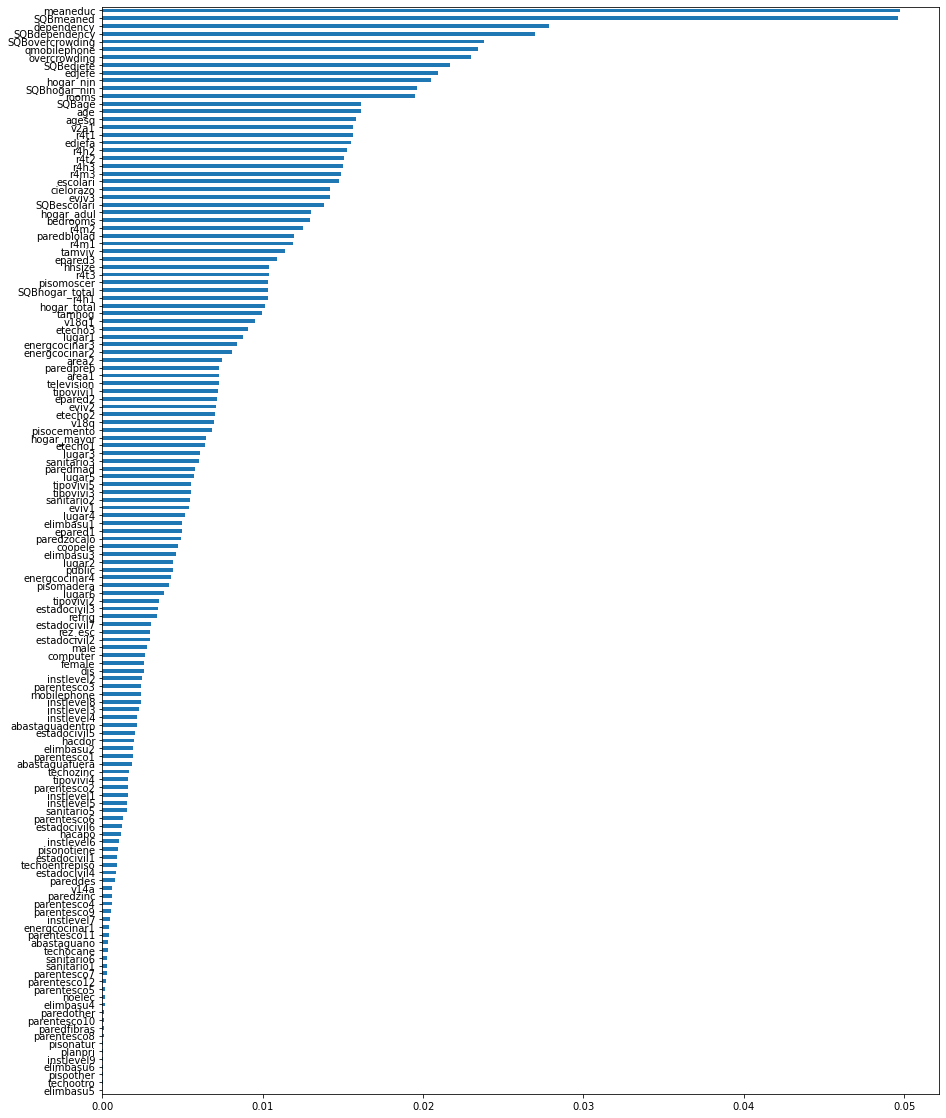

In [31]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15, 20))

# Avaliando a importancia de cada coluna (cada variável de entrada)
pd.Series(rf.feature_importances_, index=feats).sort_values().plot.barh()